## Globals

In [ ]:

path_root = "/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs"

In [ ]:
class_index = {'Adialer.C': 0,
              'Agent.FYI': 1,
              'Allaple.A': 2,
              'Allaple.L': 3,
              'Alueron.gen!J': 4,
              'Autorun.K': 5,
              'Benign': 6,
              'C2LOP.P': 7,
              'C2LOP.gen!g': 8,
              'Dialplatform.B': 9,
              'Dontovo.A': 10,
              'Fakerean': 11,
              'Instantaccess': 12,
              'Lolyda.AA1': 13,
              'Lolyda.AA2': 14,
              'Lolyda.AA3': 15,
              'Lolyda.AT': 16,
              'Malex.gen!J': 17,
              'Obfuscator.AD': 18,
              'Rbot!gen': 19,
              'Skintrim.N': 20,
              'Swizzor.gen!E': 21,
              'Swizzor.gen!I': 22,
              'VB.AT': 23,
              'Wintrim.BX': 24,
              'Yuner.A': 25}

## Setting up the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [ ]:
train_df=pd.read_csv(os.path.join(path_root,"train_combined3.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_combined3.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_combined3.csv"))

## Buliding the CNN

In [ ]:
num_classes = len(class_index.keys())

def malware_model(target_size_custom):
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

## Iterating for each image shape

In [ ]:
target_sizes_custom = [(64,64),(128,128),(256, 256)]

histories = []
generators = []

for target_size_custom in target_sizes_custom:
  root_path = f"/content/drive/MyDrive/progetto_SS/checkpoints_win_size_{str(target_size_custom[0])}_val/"
  path_pesi_old = f"/content/drive/MyDrive/progetto_SS/checkpoints_win_size_{str(target_size_custom[0])}_val/pesi/pesi.h5"
  history_saving_path_json = f"/content/drive/MyDrive/progetto_SS/checkpoints_win_size_{str(target_size_custom[0])}_val/history.json"
  save_checkpoints_path = f"/content/drive/MyDrive/progetto_SS/checkpoints_win_size_{str(target_size_custom[0])}_val/modellozzo_ckpt"

  print(history_saving_path_json)

  batch_size = 32

  datagen = ImageDataGenerator(
          rescale=1 / 255.0)

  train_gen = datagen.flow_from_dataframe(
      dataframe=train_df,
      directory=path_root,
      x_col="img_code",
      y_col="target",
      target_size=target_size_custom,
      #color_mode = "grayscale",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
  )

  val_gen = datagen.flow_from_dataframe(
      dataframe=val_df,
      directory=path_root,
      x_col="img_code",
      y_col="target",
      target_size=target_size_custom,
      #color_mode = "grayscale",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
  )


  classes = train_gen.class_indices
  train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
  class_indices =np.array(list(class_index.values()))

  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                    classes = class_indices,
                                                    y = train_labels)

  class_weights = dict(zip(np.unique(train_labels), class_weights))
  print(class_weights)



  Malware_model = malware_model(target_size_custom)

  cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")
  history = Malware_model.fit(train_gen,validation_data=val_gen, epochs=7,  class_weight=class_weights, callbacks = [cp_callback])

  histories.append(history)

  hist_df = pd.DataFrame(history.history)

  with open(history_saving_path_json, 'wb') as file_pi:
      hist_df.to_json(file_pi)



/content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/history.json
Found 6214 validated image filenames belonging to 26 classes.
Found 2054 validated image filenames belonging to 26 classes.
{0: 3.22972972972973, 1: 3.414285714285714, 2: 0.13495200451722192, 3: 0.25026178010471206, 4: 1.9916666666666667, 5: 3.734375, 6: 0.40439932318104904, 7: 2.715909090909091, 8: 1.9916666666666667, 9: 2.2336448598130842, 10: 2.438775510204082, 11: 1.0436681222707425, 12: 0.9227799227799228, 13: 1.8527131782945736, 14: 2.1339285714285716, 15: 3.1866666666666665, 16: 2.463917525773196, 17: 2.9146341463414633, 18: 2.7790697674418605, 19: 2.4895833333333335, 20: 4.979166666666667, 21: 3.0641025641025643, 22: 2.9875, 23: 0.9715447154471545, 24: 4.0508474576271185, 25: 0.4979166666666667}
Epoch 1/7
195/195 [==============================] - ETA: 0s - loss: 3.1778 - accuracy: 0.0615 - weighted_accuracy: 0.0603 
Epoch 1: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val

195/195 [==============================] - 3542s 18s/step - loss: 3.1778 - accuracy: 0.0615 - weighted_accuracy: 0.0603 - val_loss: 2.9789 - val_accuracy: 0.4177 - val_weighted_accuracy: 0.4177
Epoch 2/7
195/195 [==============================] - ETA: 0s - loss: 2.6770 - accuracy: 0.1825 - weighted_accuracy: 0.1748
Epoch 2: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/modellozzo_ckpt


195/195 [==============================] - 29s 151ms/step - loss: 2.6770 - accuracy: 0.1825 - weighted_accuracy: 0.1748 - val_loss: 2.1498 - val_accuracy: 0.4129 - val_weighted_accuracy: 0.4129
Epoch 3/7
195/195 [==============================] - ETA: 0s - loss: 2.1606 - accuracy: 0.2821 - weighted_accuracy: 0.3118
Epoch 3: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/modellozzo_ckpt


195/195 [==============================] - 29s 149ms/step - loss: 2.1606 - accuracy: 0.2821 - weighted_accuracy: 0.3118 - val_loss: 1.7821 - val_accuracy: 0.4932 - val_weighted_accuracy: 0.4932
Epoch 4/7
195/195 [==============================] - ETA: 0s - loss: 1.7370 - accuracy: 0.2969 - weighted_accuracy: 0.3984
Epoch 4: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/modellozzo_ckpt


195/195 [==============================] - 29s 151ms/step - loss: 1.7370 - accuracy: 0.2969 - weighted_accuracy: 0.3984 - val_loss: 1.3690 - val_accuracy: 0.4781 - val_weighted_accuracy: 0.4781
Epoch 5/7
195/195 [==============================] - ETA: 0s - loss: 1.5480 - accuracy: 0.3288 - weighted_accuracy: 0.4593
Epoch 5: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/modellozzo_ckpt


195/195 [==============================] - 33s 169ms/step - loss: 1.5480 - accuracy: 0.3288 - weighted_accuracy: 0.4593 - val_loss: 1.3303 - val_accuracy: 0.5185 - val_weighted_accuracy: 0.5185
Epoch 6/7
195/195 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.3719 - weighted_accuracy: 0.5129
Epoch 6: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/modellozzo_ckpt


195/195 [==============================] - 30s 152ms/step - loss: 1.3383 - accuracy: 0.3719 - weighted_accuracy: 0.5129 - val_loss: 1.2401 - val_accuracy: 0.3861 - val_weighted_accuracy: 0.3861
Epoch 7/7
195/195 [==============================] - ETA: 0s - loss: 1.2650 - accuracy: 0.3690 - weighted_accuracy: 0.5463
Epoch 7: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_64_val/modellozzo_ckpt


195/195 [==============================] - 29s 150ms/step - loss: 1.2650 - accuracy: 0.3690 - weighted_accuracy: 0.5463 - val_loss: 1.1908 - val_accuracy: 0.5063 - val_weighted_accuracy: 0.5063
/content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/history.json
Found 6214 validated image filenames belonging to 26 classes.
Found 2054 validated image filenames belonging to 26 classes.
{0: 3.22972972972973, 1: 3.414285714285714, 2: 0.13495200451722192, 3: 0.25026178010471206, 4: 1.9916666666666667, 5: 3.734375, 6: 0.40439932318104904, 7: 2.715909090909091, 8: 1.9916666666666667, 9: 2.2336448598130842, 10: 2.438775510204082, 11: 1.0436681222707425, 12: 0.9227799227799228, 13: 1.8527131782945736, 14: 2.1339285714285716, 15: 3.1866666666666665, 16: 2.463917525773196, 17: 2.9146341463414633, 18: 2.7790697674418605, 19: 2.4895833333333335, 20: 4.979166666666667, 21: 3.0641025641025643, 22: 2.9875, 23: 0.9715447154471545, 24: 4.0508474576271185, 25: 0.4979166666666667}
Epoch 1/7
195/19

195/195 [==============================] - 36s 164ms/step - loss: 3.0272 - accuracy: 0.0978 - weighted_accuracy: 0.1023 - val_loss: 2.5617 - val_accuracy: 0.1534 - val_weighted_accuracy: 0.1534
Epoch 2/7
195/195 [==============================] - ETA: 0s - loss: 2.1033 - accuracy: 0.2631 - weighted_accuracy: 0.3452
Epoch 2: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/modellozzo_ckpt


195/195 [==============================] - 33s 167ms/step - loss: 2.1033 - accuracy: 0.2631 - weighted_accuracy: 0.3452 - val_loss: 1.7105 - val_accuracy: 0.4206 - val_weighted_accuracy: 0.4206
Epoch 3/7
195/195 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.4321 - weighted_accuracy: 0.5436
Epoch 3: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/modellozzo_ckpt


195/195 [==============================] - 32s 165ms/step - loss: 1.3792 - accuracy: 0.4321 - weighted_accuracy: 0.5436 - val_loss: 1.1068 - val_accuracy: 0.7483 - val_weighted_accuracy: 0.7483
Epoch 4/7
195/195 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.5431 - weighted_accuracy: 0.6526
Epoch 4: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/modellozzo_ckpt


195/195 [==============================] - 32s 164ms/step - loss: 0.9714 - accuracy: 0.5431 - weighted_accuracy: 0.6526 - val_loss: 0.7484 - val_accuracy: 0.7249 - val_weighted_accuracy: 0.7249
Epoch 5/7
195/195 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.6304 - weighted_accuracy: 0.7228
Epoch 5: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/modellozzo_ckpt


195/195 [==============================] - 36s 183ms/step - loss: 0.7585 - accuracy: 0.6304 - weighted_accuracy: 0.7228 - val_loss: 0.7026 - val_accuracy: 0.8135 - val_weighted_accuracy: 0.8135
Epoch 6/7
195/195 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.6955 - weighted_accuracy: 0.7641
Epoch 6: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/modellozzo_ckpt


195/195 [==============================] - 42s 214ms/step - loss: 0.6247 - accuracy: 0.6955 - weighted_accuracy: 0.7641 - val_loss: 0.5373 - val_accuracy: 0.7892 - val_weighted_accuracy: 0.7892
Epoch 7/7
195/195 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7272 - weighted_accuracy: 0.7808
Epoch 7: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_128_val/modellozzo_ckpt


195/195 [==============================] - 51s 263ms/step - loss: 0.5707 - accuracy: 0.7272 - weighted_accuracy: 0.7808 - val_loss: 0.5281 - val_accuracy: 0.8393 - val_weighted_accuracy: 0.8393
/content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/history.json
Found 6214 validated image filenames belonging to 26 classes.
Found 2054 validated image filenames belonging to 26 classes.
{0: 3.22972972972973, 1: 3.414285714285714, 2: 0.13495200451722192, 3: 0.25026178010471206, 4: 1.9916666666666667, 5: 3.734375, 6: 0.40439932318104904, 7: 2.715909090909091, 8: 1.9916666666666667, 9: 2.2336448598130842, 10: 2.438775510204082, 11: 1.0436681222707425, 12: 0.9227799227799228, 13: 1.8527131782945736, 14: 2.1339285714285716, 15: 3.1866666666666665, 16: 2.463917525773196, 17: 2.9146341463414633, 18: 2.7790697674418605, 19: 2.4895833333333335, 20: 4.979166666666667, 21: 3.0641025641025643, 22: 2.9875, 23: 0.9715447154471545, 24: 4.0508474576271185, 25: 0.4979166666666667}
Epoch 1/7
195/19

195/195 [==============================] - 69s 336ms/step - loss: 2.6057 - accuracy: 0.2179 - weighted_accuracy: 0.2493 - val_loss: 2.0690 - val_accuracy: 0.5833 - val_weighted_accuracy: 0.5833
Epoch 2/7
195/195 [==============================] - ETA: 0s - loss: 1.4635 - accuracy: 0.5278 - weighted_accuracy: 0.5812
Epoch 2: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/modellozzo_ckpt


195/195 [==============================] - 66s 337ms/step - loss: 1.4635 - accuracy: 0.5278 - weighted_accuracy: 0.5812 - val_loss: 1.3689 - val_accuracy: 0.7941 - val_weighted_accuracy: 0.7941
Epoch 3/7
195/195 [==============================] - ETA: 0s - loss: 0.9384 - accuracy: 0.6971 - weighted_accuracy: 0.7137
Epoch 3: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/modellozzo_ckpt


195/195 [==============================] - 57s 291ms/step - loss: 0.9384 - accuracy: 0.6971 - weighted_accuracy: 0.7137 - val_loss: 0.6110 - val_accuracy: 0.8389 - val_weighted_accuracy: 0.8389
Epoch 4/7
195/195 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.7700 - weighted_accuracy: 0.7616
Epoch 4: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/modellozzo_ckpt


195/195 [==============================] - 48s 243ms/step - loss: 0.7229 - accuracy: 0.7700 - weighted_accuracy: 0.7616 - val_loss: 0.4436 - val_accuracy: 0.8218 - val_weighted_accuracy: 0.8218
Epoch 5/7
195/195 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.7834 - weighted_accuracy: 0.7911
Epoch 5: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/modellozzo_ckpt


195/195 [==============================] - 43s 220ms/step - loss: 0.5791 - accuracy: 0.7834 - weighted_accuracy: 0.7911 - val_loss: 0.4878 - val_accuracy: 0.8958 - val_weighted_accuracy: 0.8958
Epoch 6/7
195/195 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.8169 - weighted_accuracy: 0.8212
Epoch 6: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/modellozzo_ckpt


195/195 [==============================] - 44s 223ms/step - loss: 0.4866 - accuracy: 0.8169 - weighted_accuracy: 0.8212 - val_loss: 0.3108 - val_accuracy: 0.9226 - val_weighted_accuracy: 0.9226
Epoch 7/7
195/195 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8494 - weighted_accuracy: 0.8400
Epoch 7: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_win_size_256_val/modellozzo_ckpt


195/195 [==============================] - 43s 220ms/step - loss: 0.4243 - accuracy: 0.8494 - weighted_accuracy: 0.8400 - val_loss: 0.2987 - val_accuracy: 0.8612 - val_weighted_accuracy: 0.8612


## Model plots

dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


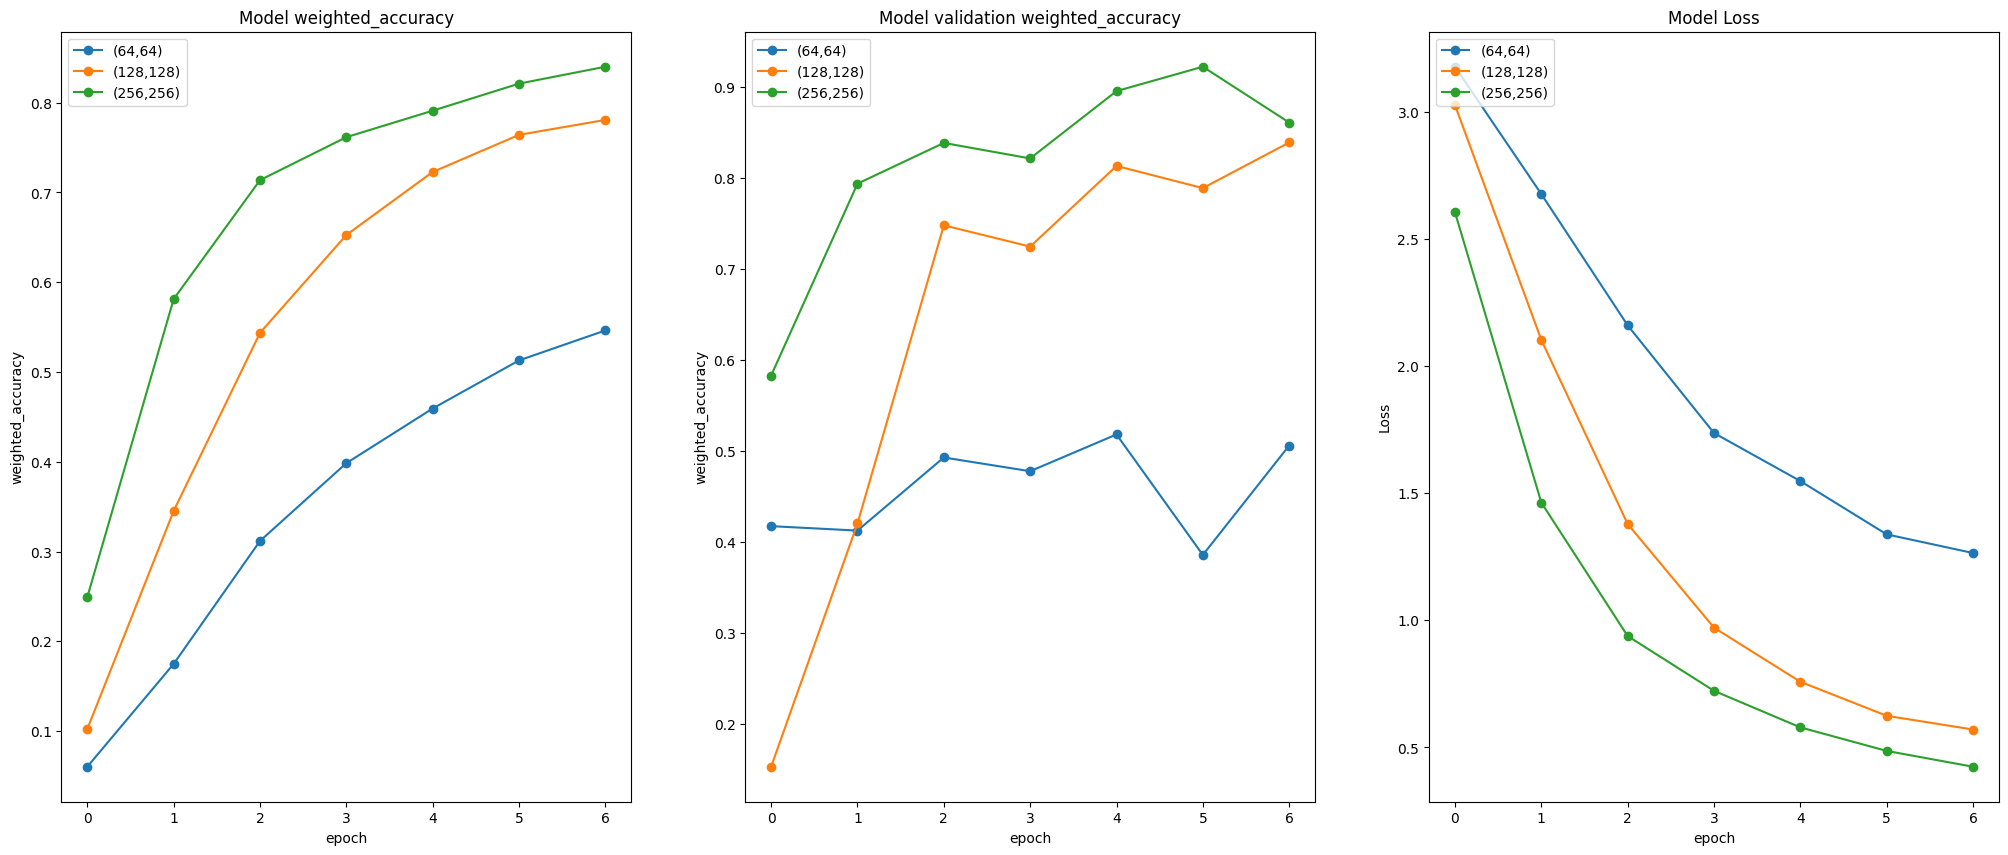

In [ ]:
print(history.history.keys())
plt.figure(figsize = (25,10))


#  "Accuracy"
plt.subplot(1,3,1)
plt.title('Model weighted_accuracy')
plt.ylabel('weighted_accuracy')
plt.xlabel('epoch')
for index,history in enumerate(histories):
  plt.plot(history.history['weighted_accuracy'], marker='o', label = f"{target_size[index]}")
plt.legend(loc='upper left')



#  "Accuracy"
plt.subplot(1,3,2)
plt.title('Model validation weighted_accuracy')
plt.ylabel('weighted_accuracy')
plt.xlabel('epoch')
for index,history in enumerate(histories):
  plt.plot(history.history['val_weighted_accuracy'], marker='o' , label = f"{target_size[index]}")

plt.legend(loc='upper left')


#  "Loss""
plt.subplot(1,3,3)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
for index,history in enumerate(histories):
  plt.plot(history.history['loss'], marker='o', label = f"{target_size[index]}")

plt.legend(loc='upper left')

plt.show()